#**Welcome, to my Vision and Perception Project "UAV Detection"**

**Author:** <br>
Alexander Busch<br>
2018082<br>
busch.2018082@studenti.uniroma1.it<br>

<br>

**Dataset:**<br>
Multi-Target Detection and Tracking from a Single Camera in Unmanned Aerial Vehicles (UAVs): https://engineering.purdue.edu/~bouman/UAV_Dataset/

<br>

**Architecture:**<br>
Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks: https://arxiv.org/abs/1506.01497



---



## Introduction:

### In this notebook I am **fine-tuning** a **pretrained Faster-RCNN** model for **UAV Detection**. <br>A standard RGB-Camera is mounted on a UAV while its flying. Based on the **RGB data**, other UAVs in the field of view should be **detected and localized**. <br> This enables a wide variety of applications like **collision avoidance, fleet-control, localization**, etc ...

Note: In this Notebook there will be context to the code, however, details regarding architecture and results will be discussed in my presentation on the 16th.

# Mount, Imports and Installs

In [1]:
#@title Mount Drive and Imports (If you want to run the notebook, please set the 'root_folder')
from google.colab import drive # import drive from google colab

ROOT = "/content/drive" #/Project_UAV_Detection       # default location for the drive

drive.mount(ROOT)
print("moved to directory:")
%cd /content/drive/MyDrive/Universität/Vision_and_Perception/Project_UAV_Detection
#%cd /content/drive/MyDrive/Project_UAV_Detection
#root_folder = '/content/drive/MyDrive/Project_UAV_Detection'
root_folder= '/content/drive/MyDrive/Universität/Vision_and_Perception/Project_UAV_Detection'
%ls

Mounted at /content/drive
moved to directory:
/content/drive/MyDrive/Universität/Vision_and_Perception/Project_UAV_Detection
checkpoint/  Drone_Detection_Comparison-2.ipynb  notebook_images/
data/        example_dataset.png                 vision/


In [2]:
from PIL import Image
import torch
import pandas as pd
import re
import os 
from numpy import index_exp
from google.colab.patches import cv2_imshow
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor


In [3]:
import sys
sys.path.append(os.path.join(root_folder, 'vision/references/detection'))

# **Dataset: Generation, Class Definition, Data Augmentation**


---



###Dataset Overview:

1.   The dataset consist of 49 video clips with a variing length from a few seconds to two minutes.
2.   The resolution is either 1080x1920 or 820x1240, always with 30 fp/s.
3. On average there are 2 UAVs visible per frame with a few negative samples (no UAV present in a frame)<br>


I convert the **videos** into single frames and stored them as **single images** to make them digestable for the model. Given that the videos have a **frame rate** of **30 FPs** and that storing all frames would bloat the dataset unnecesarily with almost redundant data , I only stored **3 frames per second**.<br>
<br>
Due to the **inability** of the model to handle **negative samples**, I skip them by loading the sample corresponding to the incremented index. <br>

The notebook is loosly inspired by various tutorials I found online.





In [4]:
#@title Create the Dataset - Extracting frames from videos and storing them as single images

vid_dir = os.path.join(root_folder,"data/videos/train")
out_dir = os.path.join(root_folder,"data/images")

def vid_to_img(video_path, out_dir, vid_idx, one_frame_each):
    video = cv2.VideoCapture(video_path) 
    success = True
    count = 0
    frame_each = one_frame_each

    if vid_idx < 10:
        vid_idx = str(vid_idx).zfill(2) #add leading zero if below 10
    else:
        vid_idx = str(vid_idx)

    while success:
        success,image = video.read()

        if success and (count%frame_each == 0): 
          cv2.imwrite("%s/%d" %(out_dir, count)+ vid_idx+".png", image) # saves images to frame folder 
        if not success:
          print(count)
          print(vid_idx)
        count += 1

    return count

one_frame_each = 10
vid_idx = 0
for vid_idx in range(0, 49):
  video_path = os.path.join(root_folder,vid_dir, "Clip_"+str(vid_idx)+".mov")
  #cnt = vid_to_img(video_path, out_dir, vid_idx, one_frame_each)
  vid_idx += 1

I used the following two Data Augmentation Methods to improve robustness:


1.   Random Flip
3.   Random Photometric Distortion



## Dataset Example with bounding box
<div>
<img src="https://raw.githubusercontent.com/2018082-Student/Vision_Project_2022/main/example_dataset_w_bboxes.png" width="800"/>
</div>
<div>


## Photometric Distortion Example
<img src="https://raw.githubusercontent.com/2018082-Student/Vision_Project_2022/main/example_photometric_data_aug.png" width="800"/>
</div>

In [5]:
#@title Data Augmentation

import transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    #transforms.append(T.ConvertImageDtype(torch.float))
    if train:
        #transforms.append(T.RandomHorizontalFlip(0.5))
        transforms.append(T.RandomIoUCrop())
        #transforms.append(T.RandomPhotometricDistort())
    return T.Compose(transforms)

In [6]:
#@title UAV Dataset 
class uav_dataset(torch.utils.data.Dataset):

    def __init__(self, root, img_dir, annotation_dir, train, transforms=None):
        self.transforms = transforms
        self.root = root
        self.annotation_dir = os.path.join(self.root, annotation_dir)
        self.img_dir = img_dir
        self.files_dir = os.path.join(self.root, self.img_dir)
        self.train = train
        #img should be png
        self.imgs = [image for image in sorted(os.listdir(self.files_dir)) if image[-4:]=='.png']
        self.imgs = self.imgs
        self.classes = [_,'uav']

    def __len__(self):
        return int( len(self.imgs) )

    # returns one dim list with length n*4
    def __prune_annotation__(self, annotations_df, frame_idx):
        
        index = frame_idx+1
        
        annotations_df.drop( index=annotations_df.index[ index: ], axis=0, inplace=True )
        annotations_df.drop( index=annotations_df.index[ :-1 ], axis=0, inplace=True )
        
        ann_list = annotations_df[0].values.tolist()[0] # to list that contains one string

        ann_list = ann_list.split() # to list that contains one entry for each word/number

        for i in range(0, len(ann_list)):
            ann_list[i] = re.sub("[^0-9]", "", str(ann_list[i])) #removes every non digit character

        ann_list = [int(x) for x in ann_list if x != ''] #removes every empty entry

        for i in range(1,len(ann_list),2):
              ann_list[i], ann_list[i+1] = ann_list[i+1], ann_list[i] # swap x and y as they are flipped in the orig dataset

        return ann_list[1:] #remove first element as it is only the timestamp

    def __idx_to_frame_and_vid__(self, idx):
        idx = self.imgs[idx][:-4] #remove .png
        frame_idx = idx[:-2] # select everything but the last two characters (reserved for vid id )
        vid_idx = idx[-2:] # last two characters for vid id
        return frame_idx, vid_idx

    def __getitem__(self, idx):

        frame_idx, vid_idx = self.__idx_to_frame_and_vid__(idx)
        
        img_path = os.path.join(self.root, "data/images/", frame_idx + vid_idx + ".png")
        img = Image.open(img_path).convert("RGB")
        
        vid_idx = vid_idx if int(vid_idx) > 10 else vid_idx[1:] #remove leading zero if present
        label_path =  os.path.join(self.root,self.annotation_dir, "Clip_"+vid_idx+"_gt.txt")
        bboxes_raw =  self.__prune_annotation__(pd.read_csv(label_path, sep='\n', header=None) , int(frame_idx))
        
        boxes = []
        if(len(bboxes_raw) != 0 ):
          for i in range( 0, len(bboxes_raw) , 4):
            boxes.append(bboxes_raw[i:i+4])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        labels = []
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)

        if len(boxes) == 0:
          return self.__getitem__(idx+1) #if empty annotation --> negative sample, take next frame
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = torch.tensor([idx]) # 000 for frist frame of clip 0
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

dataset = uav_dataset(root=root_folder, 
                            img_dir = "data/images", 
                            annotation_dir = "data/video_annotation/annotation", 
                            train =True,
                            transforms = get_transform(train=True))
[img, target] = dataset.__getitem__(100)
print(dataset.__len__())

6858


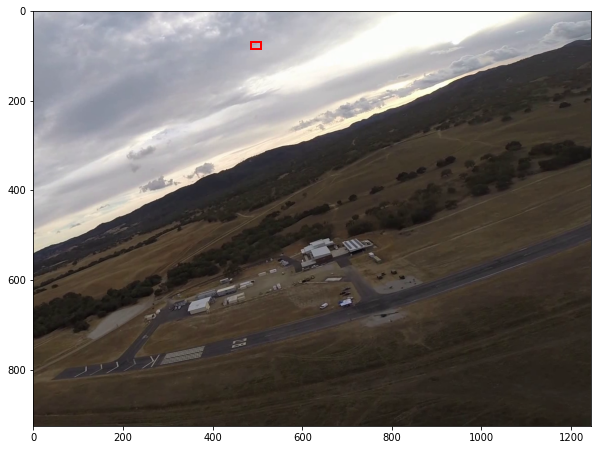

In [7]:
#@title Plot an image with bounding boxes

def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(10,10)
    a.imshow(torch.movedim(img, 0, 2))
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()
    
# plotting the image with bboxes. Feel free to change the index
plot_img_bbox(img, target)



# **Faster-RCNN**


---


### As we learned in class, the **Faster-RCNN** builds on top both **RCNN** and **Fast-RCNN**. 


### The main contribution from RCNN to Fast-RCNN is the region of interest (ROI) proposal based on the **feature maps** of the image, rather than the original image. Passing every single ROI through a network is much slower than passing the image through the network once and then look at the feature maps for ROIs. 

### The contribution from Fast-RCNN to Faster-RCNN is the subsitution of a handcrafted ROI-Selector with a **region proposal network**.

Details on the Architecture including loss computation will be given in the presentation.


<h1><center>Faster RCNN Architecture Diagram </center></h1>


<center><img src="https://raw.githubusercontent.com/2018082-Student/Vision_Project_2022/main/Faster-RCNN-Architecture.png" width="500">


## **Losses**

The network is jointly trained on four losses. <br>
**RPN classification loss:** This loss is used to classify region proposals as either object or background. The loss is calculated using the binary cross-entropy function.<br>
**RPN regression loss:** This loss is used to refine the region proposals by predicting the offsets for the bounding boxes. The loss is calculated using the smooth L1 function.<br>
**Fast R-CNN classification loss:** This loss is used to classify the object in the proposed region. The loss is calculated using the softmax cross-entropy function.<br>
**Fast R-CNN regression loss:** This loss is used to refine the bounding box coordinates for the proposed region. The loss is calculated using the smooth L1 function. 
<br>
***Note:*** that the R-CNN classification loss is of no use here since we only have one class, building the RPN classification loss however remains important! 

# **Training: Model definition, Dataset, Loader, Optimizer Initilalization**


---




In [8]:
#@title Pretrained model loading from pytorch model zoo

def get_model_fastRCNN(num_classes, v2):
    # load an instance segmentation model pre-trained on COCO
    if v2:
      model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights='DEFAULT')
    else:
      model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')

    num_classes = 2 # had to choose two 
    in_features = model.roi_heads.box_predictor.cls_score.in_features # get number of input features for the classifier
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) # replace the pre-trained head with a new one

    return model


In [9]:
#@title Dataset Initialization


num_classes = 2 # needed two classes since the loss is 
# use our dataset and defined transformations
dataset = uav_dataset(root=root_folder, 
                            img_dir = "data/images", 
                            annotation_dir = "data/video_annotation/annotation", 
                            train = True,
                            transforms = get_transform(train=True)
                            )
dataset_test = uav_dataset(root=root_folder, 
                            img_dir = "data/images", 
                            annotation_dir = "data/video_annotation/annotation", 
                            train = False,
                            transforms = get_transform(train=False)
                            )

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-300])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-300:])

In [10]:
#@title Dataloaders
import utils
# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(dataset, 
                                          batch_size=6, # 6 maxes available RAM
                                          shuffle=True, 
                                          num_workers=2,
                                          collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(dataset_test, 
                                               batch_size=1, 
                                               shuffle=False, 
                                               num_workers=2,
                                               collate_fn=utils.collate_fn)

In [11]:
#@title Loading Model from Torch Hub

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# get the model using our helper function
v2 = True
model = get_model_fastRCNN(num_classes, v2 =v2)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
#optimizer = torch.optim.SGD(params, lr=0.005,
#                          momentum=0.9, weight_decay=0.0005)
optimizer = torch.optim.Adam(params, lr=1e-3, weight_decay=1e-4)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                              step_size=3,
                                              gamma=0.1)
start_epoch = 0
warmup_factor = 1.0 / 1000
warmup_iters = min(1000, len(data_loader) - 1)

lr_scheduler = torch.optim.lr_scheduler.LinearLR(
    optimizer, start_factor=warmup_factor, total_iters=warmup_iters
)
step_size = 3

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth


  0%|          | 0.00/167M [00:00<?, ?B/s]

In [12]:
#@title Loading cumstom fine tuned Model

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#model_path = os.path.join(root_folder,"checkpoint", "fasterRCNN_SGD_no_aug_epoch_"+str(0)+".pth")
model_path = os.path.join(root_folder,"checkpoint", "fasterRCNN_V2_Adam_no_aug_epoch_"+str(8)+".pth")

checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model_state_dict'])

# construct an optimizer that will be overwritten by the checkpoint
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=1e-3, weight_decay=1e-4)
# and a learning rate scheduler that will be overwritten by the checkpoint
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                              step_size=3,
                                              gamma=0.1)
step_size = 3

optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch']+1   # saved at epoch n so we want to start from n+1
lr_scheduler.load_state_dict(checkpoint['lr_scheduler_state_dict'])


In [ ]:
#@title Saving A Model
def save_model(model_cur, optimizer_cur, lr_scheduler_cur, cur_epoch, v2):
  if v2:
    model_path = os.path.join(root_folder,"checkpoint", "fasterRCNN_V2_Adam_no_aug_epoch_"+str(cur_epoch)+".pth")
  else:
    model_path = os.path.join(root_folder,"checkpoint", "fasterRCNN_SGD_no_aug_epoch_"+str(cur_epoch)+".pth")
  print(model_path)
  torch.save({
          'epoch': cur_epoch,
          'model_state_dict': model_cur.state_dict(),
          'optimizer_state_dict': optimizer_cur.state_dict(),
          'lr_scheduler_state_dict': lr_scheduler_cur.state_dict()
          }, model_path )

In [ ]:
#@title Training Loop
import utils
import math
import sys
import time
from engine import evaluate

scaler = None
num_epochs = 10
print_freq = 50
loss_logger = []

for cur_epoch in range(start_epoch, num_epochs): #epochs

    model.train()

    #logging
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter("lr", utils.SmoothedValue(window_size=1, fmt="{value:.6f}"))
    header = f"Epoch: [{cur_epoch}]"

    #batch
    for images, targets in metric_logger.log_every(data_loader, print_freq, header): #batch

        images = list(image.to(device) for image in images) #images on device
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets] #labels on device

        #forward pass and loss computation
        with torch.cuda.amp.autocast(enabled=scaler is not None):
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        #checking loss for validity
        if not math.isfinite(losses):
            print(f"Loss is {losses}, stopping training")
            print(loss_dict)
            sys.exit(1)

        # compute gradient and update weights
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        #logging
        metric_logger.update(loss=losses, **loss_dict)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])
        loss_logger.append(metric_logger)
        

    #
    if cur_epoch == 0:
            lr_scheduler.step()

    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

    save_model(model_cur = model, 
               optimizer_cur = optimizer, 
               lr_scheduler_cur=lr_scheduler, 
               cur_epoch = cur_epoch, v2=v2)

Epoch: [6]  [   0/1093]  eta: 5:53:55  lr: 0.000002  loss: 0.1260 (0.1260)  loss_classifier: 0.0408 (0.0408)  loss_box_reg: 0.0443 (0.0443)  loss_objectness: 0.0098 (0.0098)  loss_rpn_box_reg: 0.0311 (0.0311)  time: 19.4283  data: 9.2826  max mem: 12483
Epoch: [6]  [  50/1093]  eta: 2:40:58  lr: 0.000002  loss: 0.1209 (0.1306)  loss_classifier: 0.0264 (0.0254)  loss_box_reg: 0.0387 (0.0391)  loss_objectness: 0.0171 (0.0292)  loss_rpn_box_reg: 0.0341 (0.0369)  time: 2.5682  data: 0.0466  max mem: 12611
Epoch: [6]  [ 100/1093]  eta: 1:38:53  lr: 0.000002  loss: 0.1284 (0.1336)  loss_classifier: 0.0241 (0.0244)  loss_box_reg: 0.0331 (0.0377)  loss_objectness: 0.0221 (0.0317)  loss_rpn_box_reg: 0.0346 (0.0397)  time: 2.6443  data: 0.0496  max mem: 12611
Epoch: [6]  [ 150/1093]  eta: 1:16:41  lr: 0.000002  loss: 0.1370 (0.1353)  loss_classifier: 0.0265 (0.0255)  loss_box_reg: 0.0385 (0.0389)  loss_objectness: 0.0191 (0.0305)  loss_rpn_box_reg: 0.0342 (0.0405)  time: 2.6773  data: 0.0491  ma

# **Evaluation**

The two main evaluation metrics for object detection are precision and recall.
Precision measures the proportion of the predicted bounding boxes that are correct:

**Precision = TP / (TP + FP)**

Recall measures the proportion of the ground truth bounding boxes that were correctly identified:

**Recall = TP / (TP + FN)**

We can extend these two metrics, depending on

In [18]:
#@title Collecting Losses from Log Files

def load_loss(number_of_epochs):

  loss = [] 
  loss_cls = []
  loss_box_reg = []
  loss_obj = []
  loss_rpn_box_reg = []

  for i in range(number_of_epochs):

        log_path = os.path.join(root_folder,'checkpoint', 'log_fasterRCNN_V2_Adam_no_aug', 'epoch'+str(i)+'.txt')
        loss_df = pd.read_csv(log_path, delim_whitespace=True) 
        
        loss_tmp = loss_df.iloc[:19, 9].tolist()
        loss_cls_tmp = loss_df.iloc[:19, 12].tolist()
        loss_box_reg_tmp = loss_df.iloc[:19, 15].tolist()
        loss_obj_tmp = loss_df.iloc[:19, 18].tolist()
        loss_rpn_box_reg_tmp = loss_df.iloc[:19, 21].tolist()
        
        loss += loss_tmp + loss_df.iloc[19:22, 8].tolist() 
        loss_cls += loss_cls_tmp + loss_df.iloc[19:22, 12].tolist()
        loss_box_reg += loss_box_reg_tmp + loss_df.iloc[19:22, 15].tolist()
        loss_obj += loss_obj_tmp + loss_df.iloc[19:22, 18].tolist()
        loss_rpn_box_reg += loss_rpn_box_reg_tmp + loss_df.iloc[19:22, 21].tolist()


  for i in range(0, len(loss_cls)):
        loss[i] = float(re.sub("[^0-9.]", "", str(loss[i]))) #removes every non digit character
        loss_cls[i] = float(re.sub("[^0-9.]", "", str(loss_cls[i]))) #removes every non digit character
        loss_box_reg[i] = float(re.sub("[^0-9.]", "", str(loss_box_reg[i]))) #removes every non digit character
        loss_obj[i] = float(re.sub("[^0-9.]", "", str(loss_obj[i]))) #removes every non digit character
        loss_rpn_box_reg[i] = float(re.sub("[^0-9.]", "", str(loss_rpn_box_reg[i]))) #removes every non digit character
  return loss, loss_cls, loss_box_reg, loss_obj, loss_rpn_box_reg

loss, loss_cls, loss_box_reg, loss_obj, loss_rpn_box_reg = load_loss(4)

In [14]:
#@title Collecting Evaluation from Log Files

def load_evaluations(number_of_epochs):
      precision_IoU_50_to_95_area_all = []
      precision_IoU_50_area_all = []
      precision_IoU_75_area_all = []
      precision_IoU_50_95_area_small = []
      precision_IoU_50_95_area_medium = []
      precision_IoU_50_95_area_large = []
      recall_IoU_50_95_area_all_maxDets1 = []
      recall_IoU_50_95_area_all_maxDets10 = []
      recall_IoU_50_95_area_all_maxDets100 = []
      recall_IoU_50_95_area_small = []
      recall_IoU_50_95_area_medium = []
      recall_IoU_50_95_area_large = []

      evaluations_metrics = [precision_IoU_50_to_95_area_all, precision_IoU_50_area_all,
                     precision_IoU_75_area_all, precision_IoU_50_95_area_small,
                     precision_IoU_50_95_area_medium, precision_IoU_50_95_area_large,
                     recall_IoU_50_95_area_all_maxDets1, recall_IoU_50_95_area_all_maxDets10,
                     recall_IoU_50_95_area_all_maxDets100, recall_IoU_50_95_area_small,
                     recall_IoU_50_95_area_medium, recall_IoU_50_95_area_large]

      for i in range(number_of_epochs):

          log_path_eval = os.path.join(root_folder,'checkpoint', 'log_fasterRCNN_V2_Adam_no_aug', 'epoch'+str(i)+'.txt')
          eval_df = pd.read_csv(log_path_eval, delim_whitespace=True)
          precision_IoU_50_to_95_area_all.append( float(eval_df.iloc[34, 12]))
          precision_IoU_50_area_all.append( eval_df.iloc[35, 12] )
          
          precision_IoU_75_area_all.append( eval_df.iloc[36, 12] )
          
          precision_IoU_50_95_area_small.append( float( eval_df.iloc[37, 12] ) )
          
          precision_IoU_50_95_area_medium.append(  float( eval_df.iloc[38, 11] ) )
          
          precision_IoU_50_95_area_large.append( float( eval_df.iloc[39, 12] ) )
          
          recall_IoU_50_95_area_all_maxDets1.append( float( eval_df.iloc[40, 13] ) )
          
          recall_IoU_50_95_area_all_maxDets10.append( float ( eval_df.iloc[41, 13] ) )
          
          recall_IoU_50_95_area_all_maxDets100.append( float( eval_df.iloc[42, 12] ) )
          
          recall_IoU_50_95_area_small.append( float( eval_df.iloc[43, 12] ) ) 
          
          recall_IoU_50_95_area_medium.append( float( eval_df.iloc[44, 11] ) )
          
          recall_IoU_50_95_area_large.append( float( eval_df.iloc[45, 12]  ))

      return evaluations_metrics


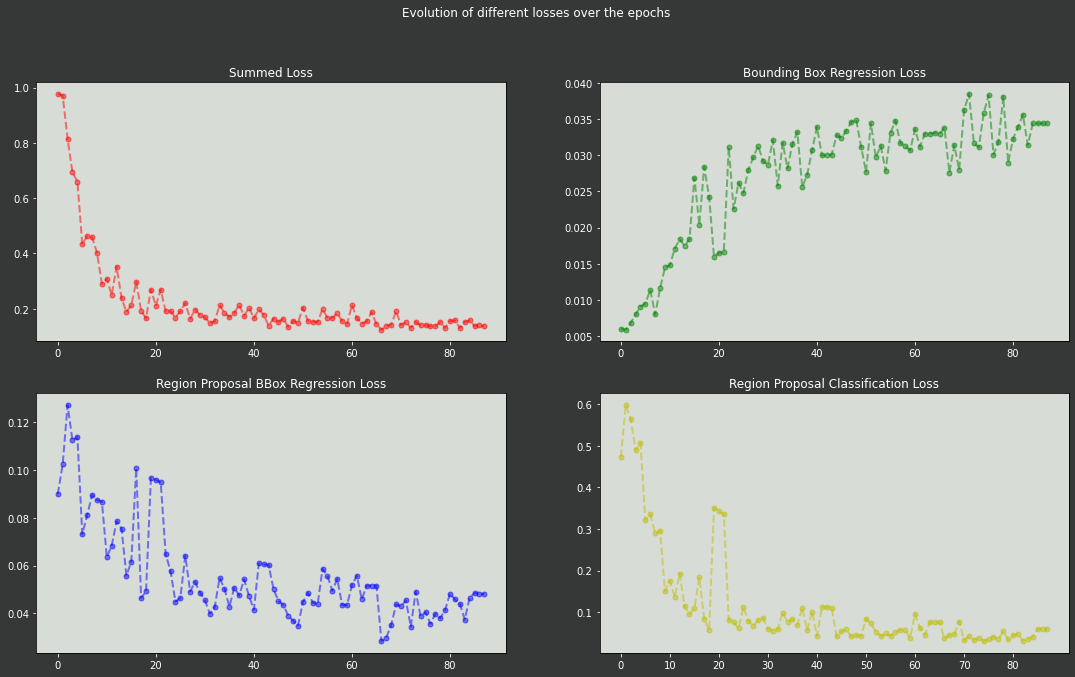

In [17]:
#@title Plotting Losses

import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from numpy import arange
from matplotlib.pyplot import figure



def plot_losses(loss, loss_box_reg, loss_rpn_box_reg, loss_obj):
      # Some example data to display
      x = range(0, len(loss))

      COLOR = 'white'
      mpl.rcParams['text.color'] = COLOR
      mpl.rcParams['axes.labelcolor'] = COLOR
      mpl.rcParams['xtick.color'] = COLOR
      mpl.rcParams['ytick.color'] = COLOR

      fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

      fig.set_size_inches(18.5, 10.5)
      fig.suptitle('Evolution of different losses over the epochs')

      ax1.plot(x, loss, marker='o', c='r', ls='--', lw=2, ms=5, alpha=.5)
      ax1.set_title('Summed Loss')
      ax2.plot(x, loss_box_reg, marker='o', c='g', ls='--', lw=2, ms=5, alpha=.5)
      ax2.set_title('Bounding Box Regression Loss')
      ax3.plot(x, loss_rpn_box_reg, marker='o', c='b', ls='--', lw=2, ms=5, alpha=.5)
      ax3.set_title('Region Proposal BBox Regression Loss')
      ax4.plot(x, loss_obj, marker='o', c='y', ls='--', lw=2, ms=5, alpha=.5)
      ax4.set_title('Region Proposal Classification Loss')

      fig.patch.set_facecolor('xkcd:dark grey')
      ax1.set_facecolor('xkcd:light grey')
      plt.xticks(arange(0, len(loss), 10))



      for ax in fig.get_axes():
        # ax.label_outer()
          ax.set_facecolor('xkcd:light grey')

plot_losses(loss, loss_box_reg, loss_rpn_box_reg, loss_obj)

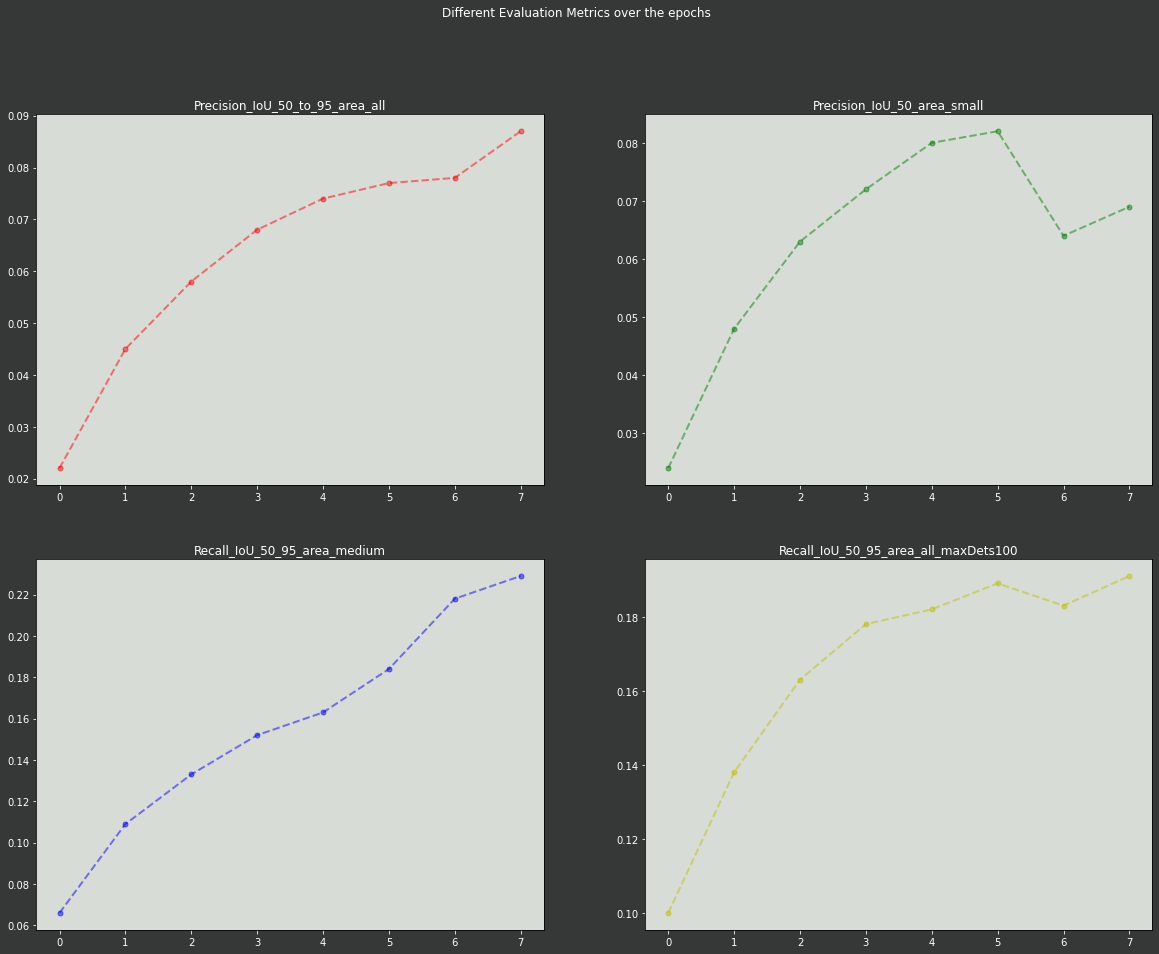

In [155]:
#@title Plotting Evaluation

import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from numpy import arange
from matplotlib.pyplot import figure


def plot_evaluations(y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,y11,y12):
      # Some example data to display
      x = range(0, len(y1))
      COLOR = 'white'
      mpl.rcParams['text.color'] = COLOR
      mpl.rcParams['axes.labelcolor'] = COLOR
      mpl.rcParams['xtick.color'] = COLOR
      mpl.rcParams['ytick.color'] = COLOR

      fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

      fig.set_size_inches(20, 15)
      fig.suptitle('Different Evaluation Metrics over the epochs')

      ax1.plot(x, y1, marker='o', c='r', ls='--', lw=2, ms=5, alpha=.5)
      ax1.set_title('Precision_IoU_50_to_95_area_all')
      ax2.plot(x, y4, marker='o', c='g', ls='--', lw=2, ms=5, alpha=.5)
      ax2.set_title('Precision_IoU_50_area_small')
      ax3.plot(x, y11, marker='o', c='b', ls='--', lw=2, ms=5, alpha=.5)
      ax3.set_title('Recall_IoU_50_95_area_medium')
      ax4.plot(x, y9, marker='o', c='y', ls='--', lw=2, ms=5, alpha=.5)
      ax4.set_title('Recall_IoU_50_95_area_all_maxDets100')

      fig.patch.set_facecolor('xkcd:dark grey')
      ax1.set_facecolor('xkcd:light grey')



      for ax in fig.get_axes():
        # ax.label_outer()
          ax.set_facecolor('xkcd:light grey')

evals = load_evaluations(8) #loading evaluation data
plot_evaluations(*evals) 

This was my project for the Vision And Perception Course.
Thank you very much!

# **END**